In [157]:
import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet, Lasso,  Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import lightgbm as lgb

from scipy import stats
from scipy.stats import norm




In [158]:
df_train = pd.read_csv('IowaHousing/train.csv')
df_train.drop('Id', axis = 1, inplace=True)

print('Train Shape:', df_train.shape)
print (df_train.head())


Train Shape: (1460, 80)
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD 

In [159]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


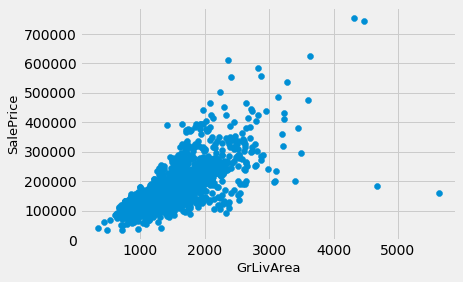

In [160]:
#Documentation mentioned outliers for sales price/GrLivArea
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Let's drop these
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

In [161]:
df_train_na = (df_train.isnull().sum() / len(df_train)) * 100
df_train_na = df_train_na.drop(df_train_na[df_train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_train_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageYrBlt,5.555556
GarageType,5.555556
GarageFinish,5.555556
GarageQual,5.555556


In [162]:
#Lets update the missing data 
#NA means no Pool, no misc feature, and no alley access...
df_train['PoolQC'] = df_train['PoolQC'].fillna('None')
df_train['MiscFeature'] = df_train['MiscFeature'].fillna('None')
df_train['Alley'] = df_train['Alley'].fillna('None')
df_train['Fence'] = df_train['Fence'].fillna('None')
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('None')

#assign missing lot frontage the median value for the house's neighborhood
df_train['LotFrontage'] = df_train.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

#replace missing data with 'None'
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_train[col] = df_train[col].fillna('None')
 
#use 0 since NA means no garage
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_train[col] = df_train[col].fillna(0)
    
#missing values mean no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_train[col] = df_train[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_train[col] = df_train[col].fillna('None')
    
#NA probably means no Masonry
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)

#use RL the most frequent value if this is missing
df_train['MSZoning'] = df_train['MSZoning'].fillna(df_train['MSZoning'].mode()[0])

#only 3 houses are not AllPub, drop them
df_train = df_train.drop(['Utilities'], axis=1)

#SBrkr is the most common for this feature, use it for missing data
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])



In [163]:
#did this clean up the missing data?
df_train_na = (df_train.isnull().sum() / len(df_train)) * 100
df_train_na = df_train_na.drop(df_train_na[df_train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_train_na})
missing_data.head(20)


,Missing Ratio


In [164]:
#some numerical values are categorical
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['OverallCond'] = df_train['OverallCond'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)


In [165]:
#apply label encoding to categorical variables that are ordered
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_train[c].values)) 
    df_train[c] = lbl.transform(list(df_train[c].values))

# shape        
print('Shape all_data: {}'.format(df_train.shape))

Shape all_data: (1458, 79)


In [166]:
#add a feature for total sq footage and bathrooms
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train['TotalBaths'] = df_train['BsmtFullBath'] + (df_train['BsmtHalfBath']*0.5) + df_train['FullBath'] + (df_train['HalfBath'] * 0.5)

In [167]:
#One hot encode categorical features
df_train = pd.get_dummies(df_train)
print(df_train.shape)


(1458, 222)


In [168]:
X = df_train.drop(['SalePrice'], axis=1)
Y = df_train['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [73]:
#Grid Search for Ridge regression hyperparameters
linear_model = Ridge()
# prepare a range of alpha values to test
alphas = np.array([0.5,0.2,0.1,0.05])
normalizes= ([True,False])

grid_search_Ridge = GridSearchCV(estimator=linear_model,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=5,
                         n_jobs=-1)

grid_search_Ridge.fit(x_train, y_train)
best_parameters_Ridge = grid_search_Ridge.best_params_  
best_score_Ridge = grid_search_Ridge.best_score_ 
print(best_parameters_Ridge)
print(best_score_Ridge)

{'alpha': 0.1, 'normalize': True}
-817772652.629885


Training R2:  0.9258686460763288
R2 Test:  0.8982200464275574
MSE: 465549366.312005


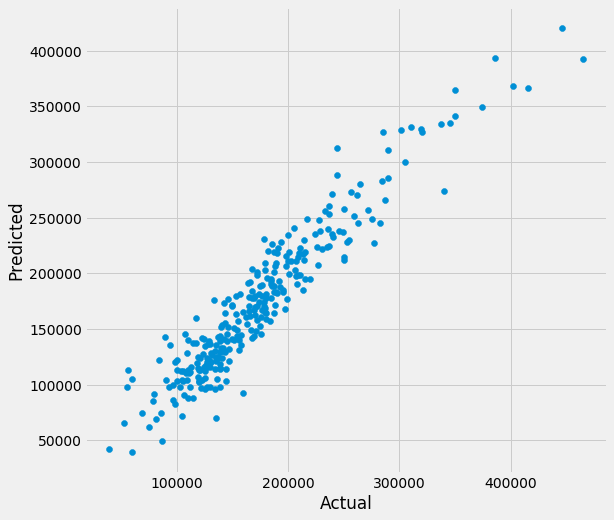

In [169]:
linear_model = Ridge(alpha=0.1, 
                     normalize=True)

linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [170]:
#Look at correlations to price
predictors = x_train.columns
coef = pd.Series(linear_model.coef_, predictors).sort_values()
print (coef)

MiscFeature_TenC       -72009.409672
Condition2_RRAe        -48629.661205
Exterior1st_ImStucc    -40140.230088
Foundation_Wood        -36680.923158
Condition2_PosN        -30410.937630
                            ...     
SaleType_Oth            31526.907876
Neighborhood_StoneBr    32764.871907
RoofStyle_Shed          35476.533885
RoofMatl_Membran        40874.155091
RoofMatl_WdShngl        66909.403273
Length: 221, dtype: float64


In [138]:
#Grid Search for optimal Lasso parameters
parameters = {'alpha': [120.0, 150.0, 175.0, 200.0]}
grid_search = GridSearchCV(Lasso(max_iter=1e5, tol=0.001), parameters, cv=3, n_jobs=-1, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'alpha': 120.0}

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25567578328.18524, tolerance: 7853198303.433371
  positive)


Training R2:  0.9174072887341284
R2 Test:  0.8947429349073058
MSE: 481453942.881665


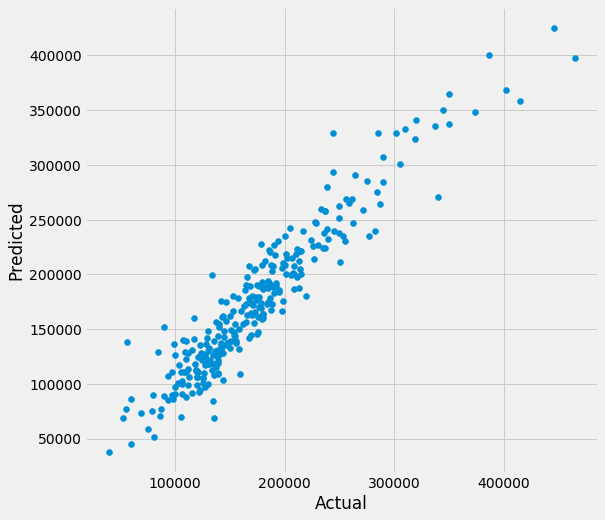

In [171]:
linear_model = Lasso(alpha=120, tol=0.001)

linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [144]:
#Grid Search for optimal ElasticNet parameters
parameters = {'alpha': [1.0, 3.0, 8.0, 10.0], 'l1_ratio': [0.25, 0.50, 0.75]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=3, n_jobs=-1, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386964088728.18176, tolerance: 718249046.3080525
  positive)


{'alpha': 1.0, 'l1_ratio': 0.75}

Training R2:  0.8995949772997313
R2 Test:  0.8890100235533218
MSE: 507676722.066472


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423955486518.1173, tolerance: 785319830.343337
  positive)


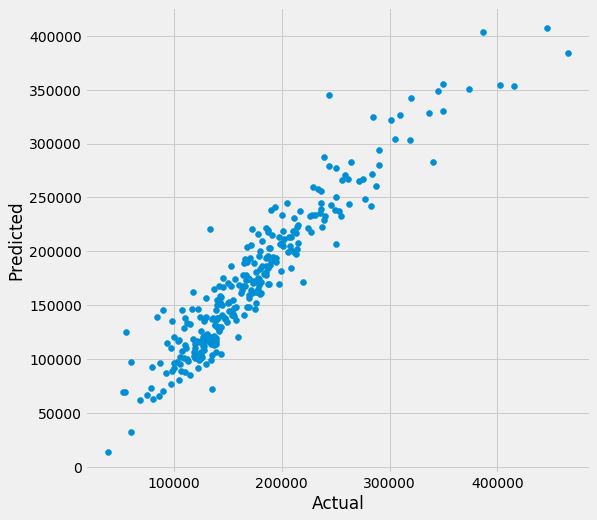

In [172]:
linear_model = ElasticNet(alpha=1, l1_ratio = 0.75)

linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [94]:
#Grid Search for optimal SVR parameters
parameters = {'C': [ 18.0, 20.0, 22.0]}
grid_search = GridSearchCV(SVR(kernel='linear', gamma=1e-4, epsilon=0.5), parameters, cv=3, n_jobs=3, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'C': 18.0}

Training R2:  0.8453888468305849
R2 Test:  0.8621089346594346
MSE: 730993306.800493


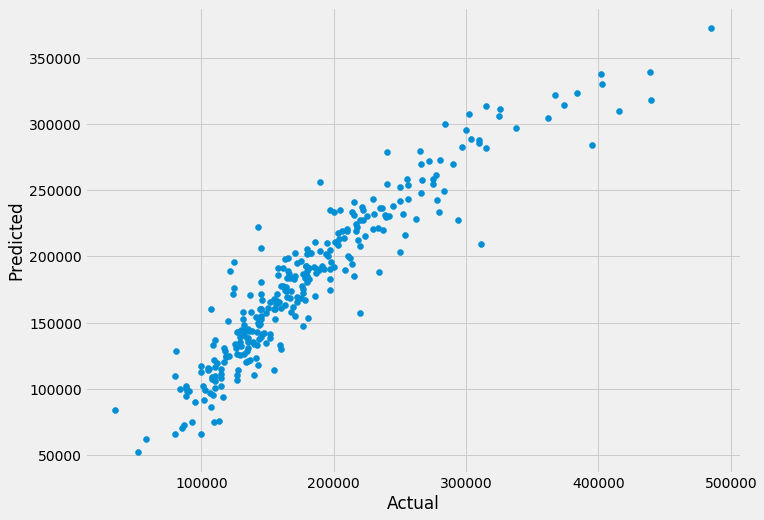

In [96]:
linear_model = SVR(kernel='linear', epsilon = 0.15, C=18.0, gamma=0.0001)

linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [97]:
#Grid Search for optimal GBR parameters
parameters = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[750,1000,1250,1500,1750],
             'max_depth': [2,4,6,8]}
grid_search = GridSearchCV(GradientBoostingRegressor(max_features='sqrt', min_samples_split=10, loss='huber', 
                                                     min_samples_leaf=15), parameters, cv=3, n_jobs=4, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 1750}

Training R2:  0.9893432872670445
R2 Test:  0.925111580482533
MSE: 342545413.185412


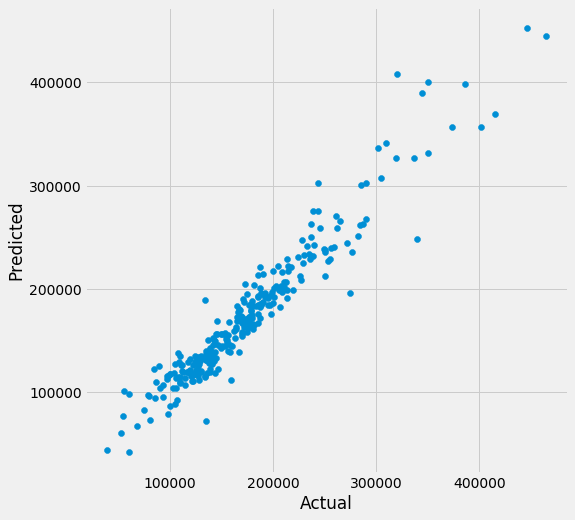

In [173]:
linear_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                         min_samples_leaf=15, min_samples_split=10, loss='huber')                                 
linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [82]:
#Grid Search for optimal XGB parameters
parameters = {"learning_rate"  : [0.05, 0.10, 0.15, 0.20] ,
 "max_depth"        : [ 3, 4, 5, 6, 8],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }
grid_search = GridSearchCV(xgb.XGBRegressor(), parameters, cv=3, n_jobs=5, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning_rate': 0.15,
 'max_depth': 3,
 'min_child_weight': 5}

[13:52:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Training R2:  0.9747261951431709
R2 Test:  0.9209516131638764
MSE: 361573424.901891


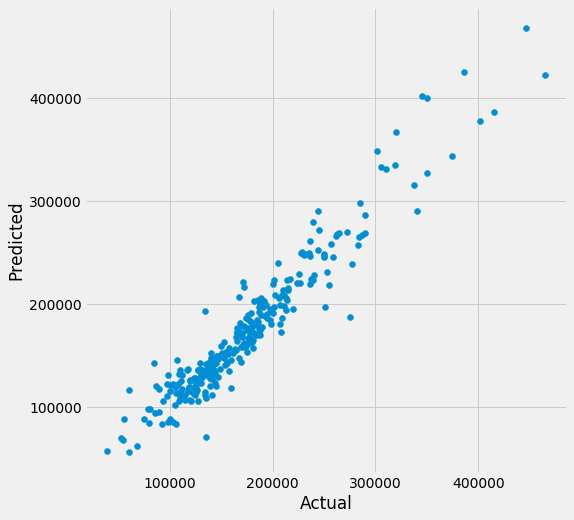

In [174]:
linear_model = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.1, 
                            learning_rate = 0.15, max_depth=3, min_child_weight=5, silent=1,nthread = -1)
linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [151]:
#Grid Search for optimal LGBM parameters
parameters = {
    'learning_rate': [0.25,0.05, 0.1,0.15],
    'n_estimators' : [400,500, 550,600]}
    
grid_search = GridSearchCV(lgb.LGBMRegressor(objective= 'regression', learning_rate = 0.05, n_estimators=720, max_bin=55, min_data_in_leaf=6, 
                                 bagging_fraction=0.8, bagging_freq=5, feature_fraction = 0.2319, feature_fraction_seed=9, num_leaves=6,
                                  bagging_seed=9, min_sum_hessian_in_leaf=11, random_state=0), parameters, cv=3, n_jobs=2, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'learning_rate': 0.05, 'n_estimators': 400}

Training R2:  0.9660243083031876
R2 Test:  0.9168067156386039
MSE: 380532506.219858


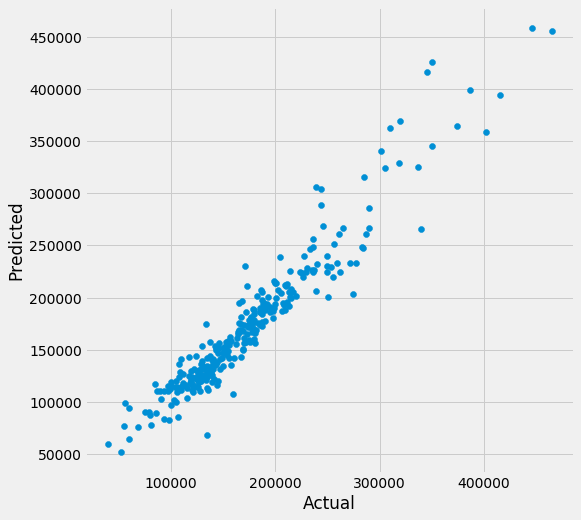

In [175]:
linear_model = lgb.LGBMRegressor(objective= 'regression', num_leaves=6, learning_rate = 0.05, n_estimators=400, max_bin=55,
                                 bagging_fraction=0.8, bagging_freq=5, feature_fraction = 0.2319, feature_fraction_seed=9, 
                                  bagging_seed=9, min_sum_hessian_in_leaf=11)
linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [118]:
#Grid Search for optimal Random Forest parameters
parameters = {'max_depth': [12, 15, 18], 'n_estimators': [1000, 1200, 1400]}
    
grid_search = GridSearchCV(RandomForestRegressor(min_samples_leaf=4, min_samples_split=8,
                                                 max_features='auto'), 
                           parameters, cv=3, n_jobs=-1, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 12, 'n_estimators': 1400}

Training R2:  0.9517072699003661
R2 Test:  0.8918696356498016
MSE: 494596635.539740


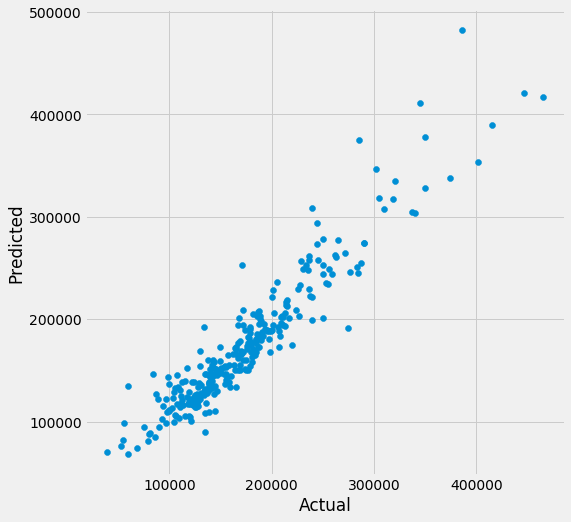

In [176]:
linear_model = RandomForestRegressor(n_estimators=1400, max_depth=12, 
                                     min_samples_split=5, min_samples_leaf=5, 
                                     max_features='auto')
linear_model.fit(x_train, y_train)
print("Training R2: ", linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)

print("R2 Test: ", r2_score(y_test, y_pred))
print('MSE: %f'% mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()